In [1]:
import numpy as np
import torch.nn
import torch.utils.data
import torch.optim
import tqdm

np.random.seed(0)
torch.manual_seed(0);

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
import datasets

In [4]:
NUM_SAMPLES = 10000
IN_SHAPE = 5
OUT_SHAPE = 1

EPOCHS = 100
BATCH_SIZE = 100
LEARNING_RATE = 5E-4

In [5]:
uniform_dataset = datasets.UniformRVDataset(num_samples=NUM_SAMPLES,
                                            shape=IN_SHAPE)
uniform_dataloader = torch.utils.data.DataLoader(uniform_dataset,
                                                 batch_size=BATCH_SIZE)

normal_dataset = datasets.NormalRVDataset(num_samples=NUM_SAMPLES,
                                          shape=OUT_SHAPE,
                                          static_sample=False)
normal_dataloader = torch.utils.data.DataLoader(normal_dataset,
                                                batch_size=BATCH_SIZE)

In [6]:
# Define generator model (simple fully-connected with leaky ReLUs).
generator = torch.nn.Sequential(
    torch.nn.Linear(IN_SHAPE, 5),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(5, 5),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(5, 5),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(5, OUT_SHAPE),
).to(device)

# Define discriminator model (simple fully-connected with leaky ReLUs).
discriminator = torch.nn.Sequential(
    torch.nn.Linear(OUT_SHAPE, 5),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(5, 5),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(5, 5),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(5, 1),
    torch.nn.Sigmoid()
).to(device)

In [7]:
# Define loss criterion (binary cross-entropy).
criterion = torch.nn.BCELoss()
# Define optimizer for generator and discriminator (Adam).
optimizerG = torch.optim.Adam(generator.parameters(), lr=LEARNING_RATE)
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=2 * LEARNING_RATE)

In [8]:
real_label = 0.9  # single-side label smoothing.
fake_label = 0
for epoch in range(EPOCHS):
    print('Epoch:', epoch)
    progress_bar = tqdm.tqdm_notebook(zip(uniform_dataloader, normal_dataloader),
                                      total=len(uniform_dataloader))
    for input_, target in progress_bar:
        input_, target = input_.float().to(device), target.float().to(device)
        # Train discriminator with real batch
        optimizerD.zero_grad()
        # Format batch
        label = torch.full_like(target[:, 0, 0], real_label, device=device)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # Forward pass real batch through D
        output = discriminator(target).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake batch
        # Generate fake batch with G
        fake = generator(input_)
        label.fill_(fake_label)
        # Forward pass fake batch through D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        optimizerG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        progress_bar.set_postfix({'Discriminator loss': errD.item(), 'Generator loss': errG.item()})

Epoch: 0



Epoch: 1



Epoch: 2



Epoch: 3



Epoch: 4



Epoch: 5



Epoch: 6



Epoch: 7



Epoch: 8



Epoch: 9



Epoch: 10



Epoch: 11



Epoch: 12



Epoch: 13



Epoch: 14



Epoch: 15



Epoch: 16



Epoch: 17



Epoch: 18



Epoch: 19



Epoch: 20



Epoch: 21



Epoch: 22



Epoch: 23



Epoch: 24



Epoch: 25



Epoch: 26



Epoch: 27



Epoch: 28



Epoch: 29



Epoch: 30



Epoch: 31



Epoch: 32



Epoch: 33



Epoch: 34



Epoch: 35



Epoch: 36



Epoch: 37



Epoch: 38



Epoch: 39



Epoch: 40



Epoch: 41



Epoch: 42



Epoch: 43



Epoch: 44



Epoch: 45



Epoch: 46



Epoch: 47



Epoch: 48



Epoch: 49



Epoch: 50



Epoch: 51



Epoch: 52



Epoch: 53



Epoch: 54



Epoch: 55



Epoch: 56



Epoch: 57



Epoch: 58



Epoch: 59



Epoch: 60



Epoch: 61



Epoch: 62



Epoch: 63



Epoch: 64



Epoch: 65



Epoch: 66



Epoch: 67



Epoch: 68



Epoch: 69



Epoch: 70



Epoch: 71



Epoch: 72



Epoch: 73



Epoch: 74



Epoch: 75



Epoch: 76



Epoch: 77



Epoch: 78



Epoch: 79



Epoch: 80



Epoch: 81



Epoch: 82



Epoch: 83



Epoch: 84



Epoch: 85



Epoch: 86



Epoch: 87



Epoch: 88



Epoch: 89



Epoch: 90



Epoch: 91



Epoch: 92



Epoch: 93



Epoch: 94



Epoch: 95



Epoch: 96



Epoch: 97



Epoch: 98



Epoch: 99


In [9]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib notebook

In [10]:
input_ = torch.tensor([uniform_dataset[i] for i in range(1000)], device=device, dtype=torch.float)
with torch.no_grad():
    # Model forward pass.
    output = generator(input_)


In [11]:
output.size()

torch.Size([1000, 1, 1])

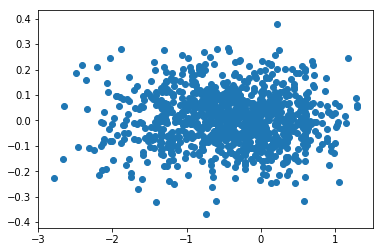

In [12]:
plt.scatter(output[:,0].transpose(1,0).tolist(), np.random.normal(0, 0.1, size=output.size(0)));

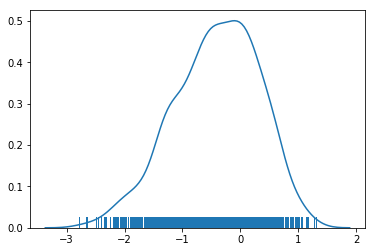

In [13]:
sns.distplot(output[:,0].cpu().numpy().T, rug=True, hist=False)

In [14]:
for o in output:
    print(o.item())


-0.1445697695016861
-0.94377201795578
0.209812730550766
-0.04212966561317444
0.6230037212371826
-0.30220603942871094
-0.18258601427078247
-0.7333046793937683
0.060207635164260864
-1.9463856220245361
-0.08323836326599121
-0.4789586663246155
0.226782888174057
-0.1313982456922531
-1.184600591659546
0.5962585210800171
-0.915986955165863
0.5802477598190308
-0.3475506901741028
-1.4434077739715576
-1.4340472221374512
-0.8789086937904358
-1.4306843280792236
0.3750802278518677
-0.6668277978897095
-1.1915581226348877
-0.2097284197807312
-1.3489634990692139
-0.19207853078842163
0.9151989817619324
0.01597316563129425
-1.3078348636627197
-0.17467863857746124
-1.3467063903808594
0.13392138481140137
-1.0306637287139893
-0.7853797674179077
-0.2723104655742645
-1.2092812061309814
0.2314237356185913
-0.5079944133758545
0.309506893157959
0.19039997458457947
0.18810096383094788
0.20682498812675476
0.08629223704338074
-0.46258577704429626
-1.5967390537261963
-1.6916859149932861
-0.5291053056716919
-1.41256

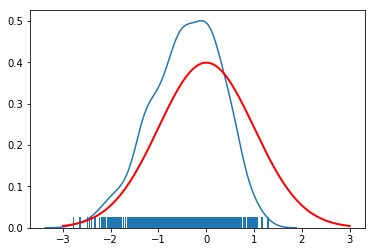

In [15]:
from scipy import stats                                                         

ax = sns.distplot(output[:,0].cpu().numpy().T, rug=True, hist=False)

# calculate the pdf over a range of values
xx = np.arange(-3, +3, 0.001)                                                   
yy = stats.norm.pdf(xx)                                                         
# and plot on the same axes that seaborn put the histogram
ax.plot(xx, yy, 'r', lw=2)  